In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from ydata_profiling import ProfileReport

In [2]:
data = pd.read_excel("IMPORTACION-VOLUMEN-2024-05.xlsx", index_col="Fecha", parse_dates=["Fecha"], date_format="%Y-%m-%d ", skiprows=6, skipfooter=3)

import_data = data[['Gasolina regular', 'Gasolina superior', 'Gas licuado de petróleo']]
import_data

,Gasolina regular,Gasolina superior,Gas licuado de petróleo
Fecha,,,
2001-01-01 00:00:00,177776.50,373963.96,194065.738095
2001-02-01 00:00:00,123115.99,243091.07,170703.380952
2001-03-01 00:00:00,161726.42,312084.38,161837.371429
2001-04-01 00:00:00,127338.74,285054.89,163048.642857
2001-05-01 00:00:00,168730.19,300913.67,171518.861905
...,...,...,...
2024-01-01 00:00:00,914133.32,712333.33,701570.800000
2024-02-01 00:00:00,740662.25,650360.11,916541.700000
2024-03-01 00:00:00,838270.93,620077.74,675157.480000


In [3]:
start_date = '2017-12-01'

import_data['Diesel'] = np.where((data.index <= start_date),
                                    data['Diesel alto azufre'],
                                    data['Diesel bajo azufre'])

import_data['Diesel']

/tmp/ipykernel_3709/2775745780.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import_data['Diesel'] = np.where((data.index <= start_date),


Fecha
2001-01-01 00:00:00     566101.99
2001-02-01 00:00:00     489525.80
2001-03-01 00:00:00     575559.68
2001-04-01 00:00:00     437745.42
2001-05-01 00:00:00     552609.13
                          ...    
2024-01-01 00:00:00    1409097.15
2024-02-01 00:00:00    1236861.75
2024-03-01 00:00:00    1477038.00
2024-04-01 00:00:00    1294706.12
2024-05-01 00:00:00    1470870.09
Name: Diesel, Length: 281, dtype: float64

In [4]:
import_profile = ProfileReport(import_data, explorative=True)
import_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [116]:
inicio = min(import_data.index)
inicio
values = import_data.loc[inicio]
print("Fecha: ", inicio, "Valor: ", values['Gasolina superior'])

Fecha:  2001-01-01 00:00:00 Valor:  373963.96


In [117]:
fin = max(import_data.index)
fin
values = import_data.loc[fin]
print("Fecha: ", fin, "Valor: ", values['Gasolina superior'])

Fecha:  2024-05-01 00:00:00 Valor:  696970.3


In [118]:
infer_frec = pd.infer_freq(import_data['Gasolina superior'].index)
infer_frec

'MS'

In [119]:
# Replace zero values with NaN
import_data = import_data.replace(0, np.nan)

# Drop rows with NaN values (which were originally zero values)
import_data = import_data.dropna()

/var/folders/nh/qxcg2qs54dq8v4tnbxqzpm7w0000gn/T/ipykernel_42829/1110981822.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  import_data_yearly = import_data.resample('Y').sum()


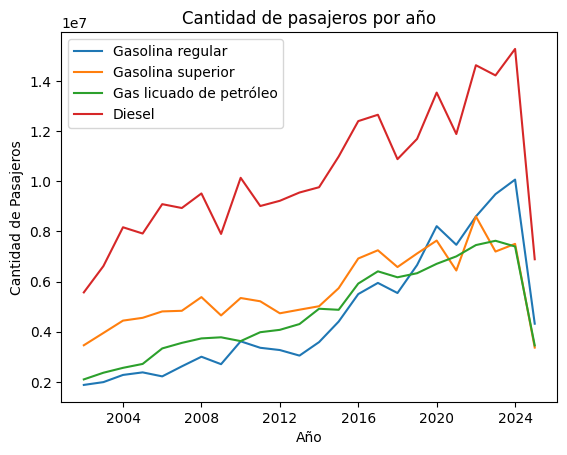

In [120]:
import matplotlib.dates as mdates

# Assuming consume_data is already loaded

# Ensure the index is a DatetimeIndex
if not isinstance(import_data.index, pd.DatetimeIndex):
    import_data.index = pd.to_datetime(import_data.index)

# Group the data by year and sum the values
import_data_yearly = import_data.resample('Y').sum()

# Plot the aggregated data
plt.plot(import_data_yearly)

# Set the title and labels
plt.gca().set(title="Cantidad de pasajeros por año", xlabel="Año", ylabel="Cantidad de Pasajeros")

# Format the x-axis to display only the year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a legend
plt.legend(import_data.columns)

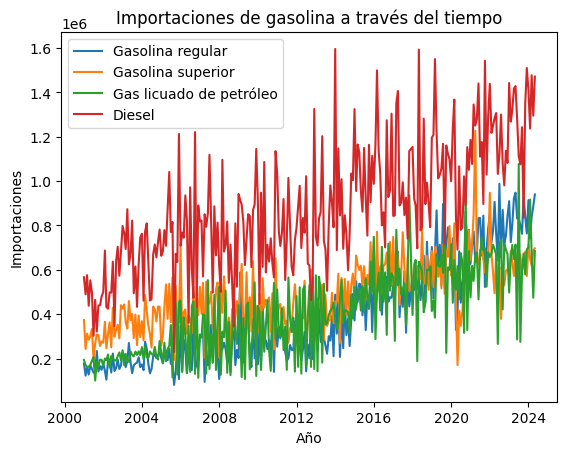

In [121]:
plt.plot(import_data)
plt.gca().set(title="Importaciones de gasolina a través del tiempo", xlabel="Año", ylabel="Importaciones")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend(import_data.columns)
plt.show()

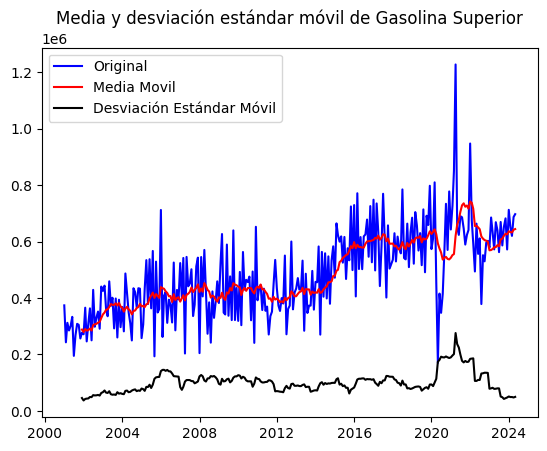

In [122]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = import_data['Gasolina superior'].rolling(window=12).mean()
deMovil = import_data['Gasolina superior'].rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(import_data['Gasolina superior'], color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil de Gasolina Superior')
plt.show(block=False)

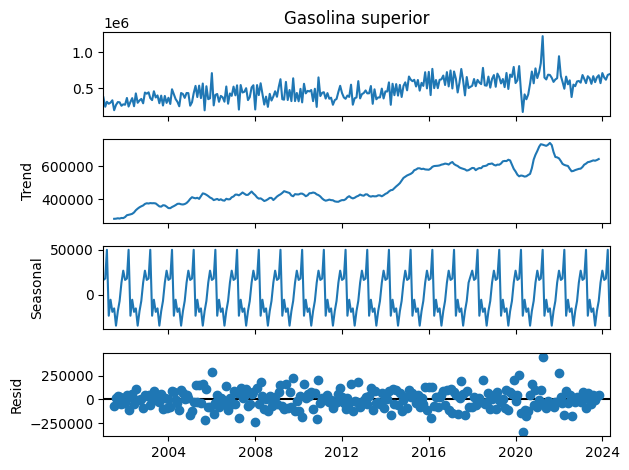

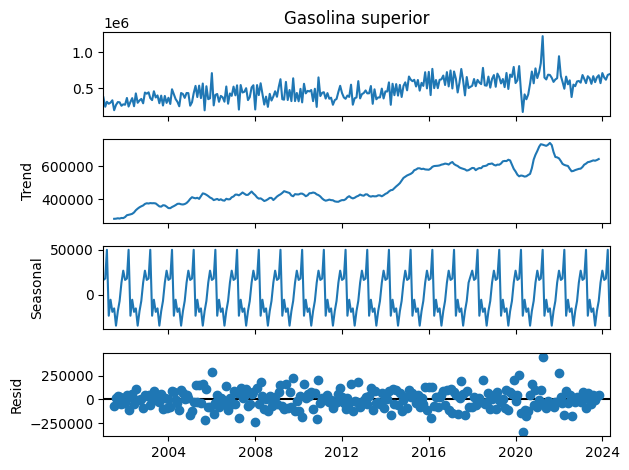

In [123]:
descomposicion = seasonal_decompose(import_data['Gasolina superior'], model='additive', period=12)
descomposicion.plot()

In [124]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(import_data['Gasolina superior'], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -2.923066
p-value                        0.042731
# de retardos usados           3.000000
# de observaciones usadas    276.000000
Critical Value (1%)           -3.454267
Critical Value (5%)           -2.872070
Critical Value (10%)          -2.572381
dtype: float64


Text(0.5, 1.0, 'Función de Autocorrelación con 12 retardos')

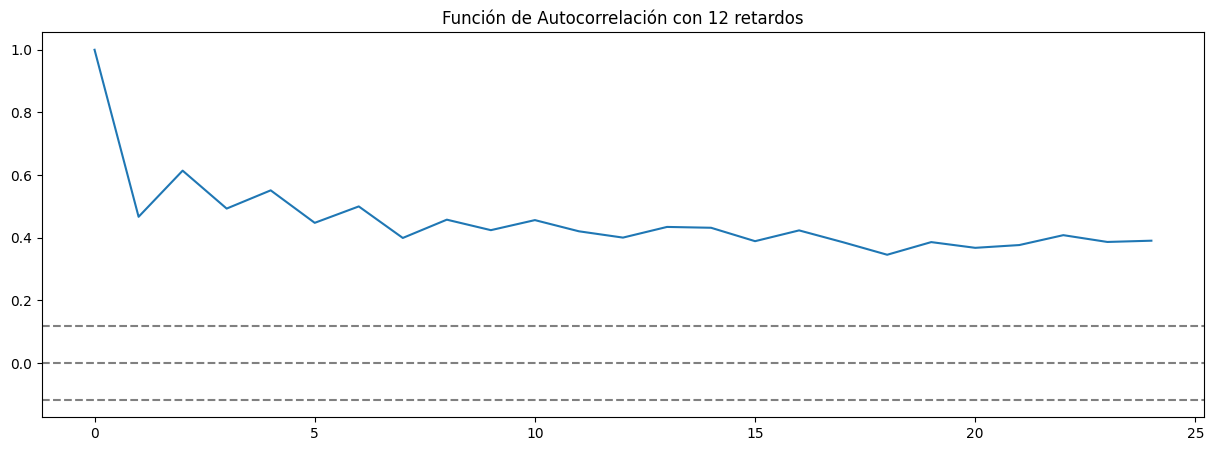

In [125]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.plot(acf(import_data['Gasolina superior'],nlags=24,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(import_data['Gasolina superior'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(import_data['Gasolina superior'])),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')